This notebook provides an introduction to using Obspy, the main python package used for seismic data analysis, through the example of an amphibious (both ocean- and land-based) earthquake catalog.

The documentation for Obspy can be found here:
https://docs.obspy.org/index.html

We start by looking at what kind of data is stored in an earthquake catalog, and then we look at how to download and plot up seismic time series data.

In [1]:
import obspy
import numpy as np
from obspy.clients.fdsn.client import Client
import cartopy
import pandas as pd
import geopandas as gpd
from collections import defaultdict

#### Included in this repository is a QuakeML file, a standard file type in the seismic community that stores earthquake catalog information.
#### This file contains 1 month of catalog data from the Alaska Amphibious Community Seismic experiment.
The catalog is publicly available at https://scholarworks.alaska.edu/handle/11122/11967.

In [2]:
# Make an obspy Catalog object from the QuakeML file.
cat = obspy.core.event.read_events('XO_2019_01.quakeml')

#### We see that during for the month of January 2019, the catalog includes 397 earthquakes.

In [6]:
print(cat)

397 Event(s) in Catalog:
2019-01-01T05:05:56.545000Z | +54.392, -161.458 | 2.4  ml | manual
2019-01-01T06:15:44.168000Z | +54.206, -161.556 | 2.9  ml | manual
...
2019-01-30T16:51:27.897000Z | +55.729, -149.053 | 2.6  ml | manual
2019-01-31T15:17:14.995000Z | +56.176, -148.860 | 2.8  ml | manual
To see all events call 'print(CatalogObject.__str__(print_all=True))'


#### Let's convert this to a pandas dataframe with some basic information about each earthquake.

In [3]:
origins = [p.origins[0] for p in cat.events]
magnitudes = [p.magnitudes[0] for p in cat.events]


times = [p.time for p in origins]
lats = [p.latitude for p in origins]
lons = [p.longitude for p in origins]
depths = [p.depth for p in origins]
arrivals = [len(p.arrivals) for p in origins]
origin_ids = [str(p.resource_id) for p in origins]
mags = [p.mag for p in magnitudes]
mag_type = [p.magnitude_type for p in magnitudes]
origin_dict = {'time':times,'latitude':lats,'longitude':lons,'depth':depths,'num_arrivals':arrivals,'origin_id':origin_ids,'magnitude':mags,'mag_type':mag_type}

events = pd.DataFrame.from_dict(origin_dict)
events['time'] = [str(t) for t in events['time']]
events.head()

,time,latitude,longitude,depth,num_arrivals,origin_id,magnitude,mag_type
0,2019-01-01T05:05:56.545000Z,54.3925,-161.4584,25600.0,35,quakeml:earthquake.alaska.edu/origin/0191qjphy,2.4,ml
1,2019-01-01T06:15:44.168000Z,54.2056,-161.5565,62000.0,66,quakeml:earthquake.alaska.edu/origin/0191r79en,2.9,ml
2,2019-01-01T06:18:21.851000Z,57.1614,-157.9859,133100.0,161,quakeml:earthquake.alaska.edu/origin/0191r7uq7,3.0,ml
3,2019-01-01T11:12:56.407000Z,55.7353,-149.1689,18600.0,162,quakeml:earthquake.alaska.edu/origin/0191u5who,3.5,ml
4,2019-01-01T12:38:14.804000Z,54.2502,-161.6862,42100.0,91,quakeml:earthquake.alaska.edu/origin/0191uwq6k,3.5,ml


#### Let's make a quick map of where these earthquakes are located, colored by their magnitude.

In [81]:
events['time']=pd.to_datetime(events['time'],format='%Y-%m-%dT%H:%M:%S.%fZ',errors='coerce')
gf = gpd.GeoDataFrame(events.drop(columns='time').copy(), 
                      geometry=gpd.points_from_xy(events.longitude,events.latitude),
                      crs=4326)
gf.explore(column='magnitude')

#### But each earthquake has a lot more data with it- information for its picked phase arrivals, an origin calculation (a location and origin time calculated from the phase arrivals), and a magnitude calculation (calculated from amplitudes).

In [22]:
ev1 = cat[0]
print(ev1)

Event:	2019-01-01T05:05:56.545000Z | +54.392, -161.458 | 2.4  ml | manual

	            resource_id: ResourceIdentifier(id="quakeml:earthquake.alaska.edu/event/0191qjphy")
	             event_type: 'earthquake'
	          creation_info: CreationInfo(agency_id='AK', author='Alaska Earthquake Center, UAF/GI', creation_time=UTCDateTime(2021, 3, 24, 1, 26, 13, 820000), version='1')
	    preferred_origin_id: ResourceIdentifier(id="quakeml:earthquake.alaska.edu/origin/0191qjphy")
	 preferred_magnitude_id: ResourceIdentifier(id="quakeml:earthquake.alaska.edu/magnitude/0191qjphy/ml")
	                   ---------
	                  picks: 35 Elements
	                origins: 1 Elements
	             magnitudes: 1 Elements


#### For this earthquake, there were 35 picks (identified P- or S-wave arrivals in time series). For each "pick", there are two pieces of stored information- the station and channel information for the pick, stored in the picks object:

In [23]:
ev1.picks[0]

Pick
	     resource_id: ResourceIdentifier(id="quakeml:earthquake.alaska.edu/pick/95")
	            time: UTCDateTime(2019, 1, 1, 5, 6, 5, 601000)
	     waveform_id: WaveformStreamID(network_code='XO', station_code='LT20', channel_code='HHZ', location_code='--')
	 evaluation_mode: 'manual'
	   creation_info: CreationInfo(agency_id='AK', author='Alaska Earthquake Center, UAF/GI', creation_time=UTCDateTime(2020, 12, 19, 2, 35, 50, 415000))

#### As well as the arrival information for the pick, which tells us whether it was identified as a P or S wave arrival and what weight it received when it was used for location of the earthquake. This is stored within the origins object.

In [24]:
ev1.origins[0].arrivals[0]

Arrival
	   resource_id: ResourceIdentifier(id="quakeml:earthquake.alaska.edu/arrival/95")
	       pick_id: ResourceIdentifier(id="quakeml:earthquake.alaska.edu/pick/95")
	         phase: 'P'
	       azimuth: 6.76
	      distance: 0.411
	 time_residual: -0.014
	   time_weight: 0.265
	 creation_info: CreationInfo(agency_id='AK', author='Alaska Earthquake Center, UAF/GI', creation_time=UTCDateTime(2020, 12, 19, 2, 35, 50, 415000))

#### You can see these two pieces of pick information can be joined by their pick_id and resource_id.
#### By rounding up all the picks for all the earthquakes in the catalog, we can get a list of which stations were used to make this earthquake catalog and query their information from the seismic database IRIS.

In [25]:
# Get a list of all station-channel pairs that have picks
picks = [p.picks for p in cat.events]
picks = sum(picks,[])

networks = [p.waveform_id.network_code for p in picks]
stations = [p.waveform_id.station_code for p in picks]
channels = [p.waveform_id.channel_code[0:2] + '*' for p in picks]
# Toss pressure channels:
channelToRemove = 'HD*'
channels = [value for value in channels if value != channelToRemove]

sta_list = [f"{n}.{s}..{c[0:2]}" for n, s, c in zip(networks,stations,channels)]
sta_list = np.unique(sta_list)

# Get all the info for those stations from IRIS
network = ",".join((np.unique(networks)).tolist())
channel = ",".join((np.unique(channels)).tolist())
station = ",".join((np.unique(stations)).tolist())

origins = [p.origins for p in cat.events]
times = [p[0].time for p in origins]
starttime = np.min(times)
endtime = np.max(times)

sta_metadata = Client("iris").get_stations(starttime=starttime,endtime=endtime,network=network,channel=channel,station=station,location='',level='response')

#### Now we have a station inventory object, with a lot of stations, wow (almost 500)!
#### Let's convert that to a pandas dataframe and plot it up the same way we did the earthquakes.

In [31]:
station_locs = defaultdict(dict)
for network in sta_metadata:
    for station in network:
        for chn in station:
            sid = f"{network.code}.{station.code}.{chn.location_code}.{chn.code[:-1]}" + chn.start_date.strftime('%Y%j')
            if sid in station_locs:
                station_locs[sid]["component"] += f",{chn.code[-1]}"
                station_locs[sid]["response"] += f",{chn.response.instrument_sensitivity.value:.2f}"
            else:
                component = f"{chn.code[-1]}"
                response = f"{chn.response.instrument_sensitivity.value:.2f}"
                dtype = chn.response.instrument_sensitivity.input_units.lower()
                tmp_dict = {}
                tmp_dict["longitude"], tmp_dict["latitude"], tmp_dict["elevation(m)"] = (
                    chn.longitude,
                    chn.latitude,
                    chn.elevation,
                )
                tmp_dict["component"], tmp_dict["response"], tmp_dict["unit"] = component, response, dtype
                tmp_dict["start_date"], tmp_dict["end_date"] = chn.start_date,chn.end_date
                tmp_dict["network"], tmp_dict["station"] = network.code, station.code
                station_locs[sid] = tmp_dict

station_locs = pd.DataFrame.from_dict(station_locs,orient='index')
station_locs["id"] = station_locs.index
# Remove the date from ID
station_locs['id']=station_locs['id'].str.slice(stop=-7)

#### We see that the earthquake catalog contains pick information for both onshore and offshore stations throughout Alaska in the map below, colored by station elevation.

In [82]:
gf = gpd.GeoDataFrame(station_locs.drop(columns=['start_date','end_date']).copy(), 
                      geometry=gpd.points_from_xy(station_locs.longitude,station_locs.latitude),
                      crs=4326)
gf.explore(column='elevation(m)')

## So that's a basic intro to catalog data. Now, let's look at some continuous waveforms.

### We can pull time series data for a given set of channels for a given amount of time from the IRIS database: https://ds.iris.edu/ds/nodes/dmc/
### We do this using the Obspy package.
### Let's look at the time series for one of the larger earthquakes in the catalog, a magnitude 5.

In [70]:
# Grab the pick information for the earthquake from the catalog object
# I've just chosen here a station that has a pretty obvious arrival, but you could look at other
# picks by changing the index i
ev1 = cat[7]
i = 20
pick = ev1.picks[i]
arr = ev1.origins[0].arrivals[i]

# Let's gather the information we need to query seismic waveforms

# A start and end time, let's call it 3 minutes before and after the pick time
t1 = pick.time - 3*60
t2 = pick.time + 3*60

# The network, station, and location code, as well as the channel prefix- this pick is on the HHZ channel,
# the vertical channel, but we can pull all channels of data from the station using a wildcard
network = pick.waveform_id.network_code
station = pick.waveform_id.station_code
location = pick.waveform_id.location_code
channel = pick.waveform_id.channel_code[0:2] + '*'

# Specify which data center we want to pull data from using Obspy's "Client" services
client = Client("IRIS")

# Download the waveform
stream = client.get_waveforms(network,station,location,channel,t1,t2)

#### Now we have a "stream" object, which contains multiple channels of time series data.
#### We can plot it up nicely using the built in functions- let's look at the raw data. We can see the earthquake arrive in the middle of the window.

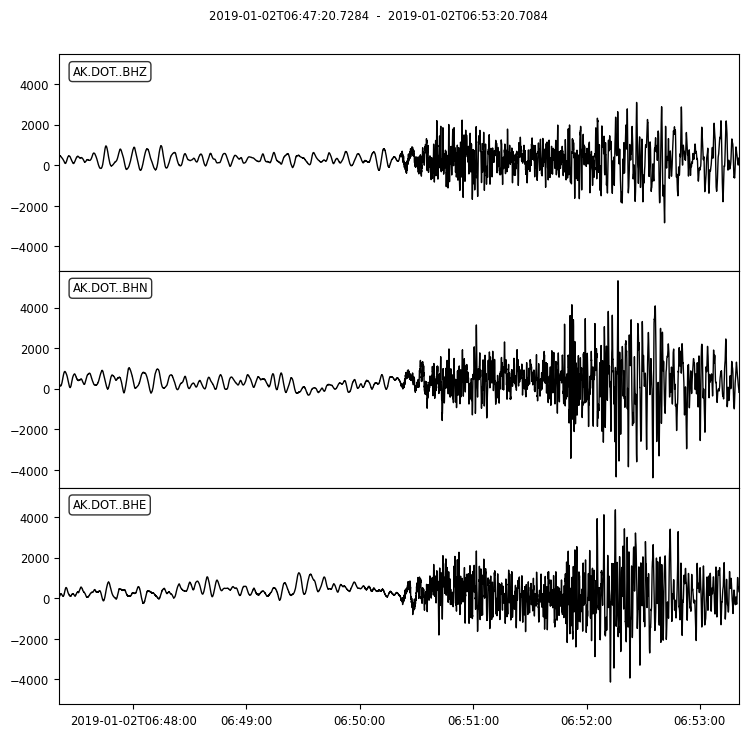

In [72]:
stream.plot();

#### We see that each channel has metadata associated with it, including sampling rate information. Each channel is a separate "Trace" object.

In [77]:
print(stream)
print(stream[0].stats)

3 Trace(s) in Stream:
AK.DOT..BHE | 2019-01-02T06:47:20.728400Z - 2019-01-02T06:53:20.708400Z | 50.0 Hz, 18000 samples
AK.DOT..BHN | 2019-01-02T06:47:20.728400Z - 2019-01-02T06:53:20.708400Z | 50.0 Hz, 18000 samples
AK.DOT..BHZ | 2019-01-02T06:47:20.728400Z - 2019-01-02T06:53:20.708400Z | 50.0 Hz, 18000 samples
               network: AK
               station: DOT
              location: 
               channel: BHE
             starttime: 2019-01-02T06:47:20.728400Z
               endtime: 2019-01-02T06:53:20.708400Z
         sampling_rate: 50.0
                 delta: 0.02
                  npts: 18000
                 calib: 1.0
_fdsnws_dataselect_url: http://service.iris.edu/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({'dataquality': 'M', 'number_of_records': 46, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 68608})
            processing: ['ObsPy 1.3.0: trim(endtime=UTCDateTime(2019, 1, 2, 6, 53, 20, 72840

#### The actual time series data is stored as a numpy array with each trace.

In [78]:
stream[0].data

array([ 86,  85,  89, ..., 370, 347, 328], dtype=int32)

#### We can easily filter the waveforms using built in functions and see the difference in the plot.

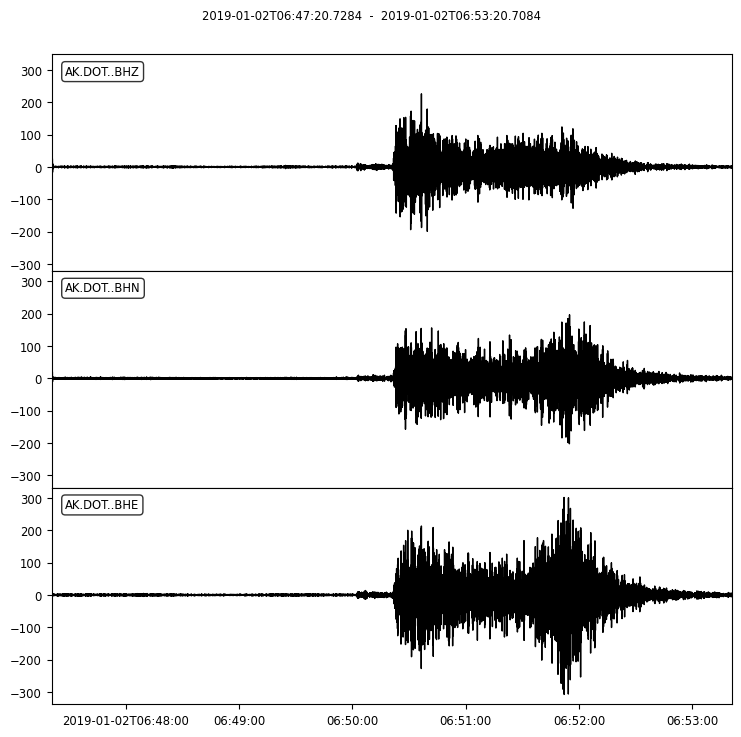

In [80]:
stream.filter('bandpass',freqmin=5,freqmax=15)
stream.plot();

## This process of pulling in waveforms is highly flexible and can be done for any stations available in the IRIS DMC. This is a useful page to play around and browse what's available from IRIS:
http://ds.iris.edu/gmap/#network=XO&starttime=2013-01-01T00:00:00&endtime=2599-12-31T23:59:59&planet=earth

## And if you want to look at different earthquakes, the USGS catalog is a great place to find some:
https://earthquake.usgs.gov/earthquakes/search/

#### And I haven't taken the time to package this up more cleanly, but the notebook at this link is an example of how to apply pre-trained convolutional neural networks to seismic time series using the package Seisbench. In the case of this example, the purpose of the CNNs is to "denoise" the seismograms by distinguishing earthquake signals from learned noise signals:
https://github.com/scottyhq/quakeflow-examples/blob/main/deepdenoiser_obsexamples.ipynb